<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/03_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 불러오기

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

사이킷런에서 읽은 데이터셋은 dictionary 구조를 가지고 있다.
- 데이터셋을 설명하는 DESCR 키
- 샘플을 행, 특성(feature)를 열로 구성된 배열 data 키
- 레이블 배열이 있는 target 키

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
print(28*28)

(70000, 784)
(70000,)
784


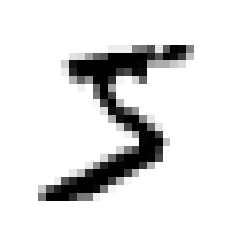

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary") # cmp="gray" 하면 높은 값을 밝게 하면서 색이 반전됨
plt.axis("off")
plt.show()

실제 레이블 확인

In [ ]:
y[0]

'5'

정수로 변환

In [ ]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

여러 이미지 출력(간단하게만)

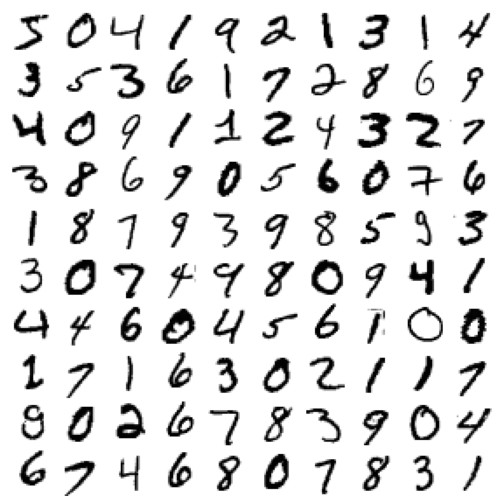

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

첫 6만개를 train으로, 나머지를 test로 나누기

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련
문제 단순화를 위해, 5만 분류하는 모델

In [ ]:
y_train_5 = (y_train == 5) # 5이면 True, 아니면 False
y_test_5 = (y_test == 5)
y_test_5[:3]

array([False, False, False])

사이킷런의 __SGDClassifier__ 클래스를 사용해 Stochastic Gradient Descent 적용(하나의 샘플을 독립적으로 처리)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

- SGDClassifier(혹은 SGDRegressor)는 훈련하는데 무작위성을 가져서 Stocahstic이라 불림 (시계열 데이터엔 비적합)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차검증을 사용한 방법


#### a. 단순 교차검정

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### b. 계층적 샘플링 교차검정

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds)

array([0.9669 , 0.91625, 0.96785])

위의 과정을 수동으로 구현하면 다음과 같다

In [ ]:
from sklearn.base import clone

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- 여기서 clone은 데이터까지 복사하는 것이 아니라, 모델만 복사하는 함수다.

#### c. Accuracy 한계
지금까지의 예시에서 무조건 5가 아니라고 예측한 모델을 만들면 꽤 높은 정확도가 나온다.<br>
따라서, 정확도만 살펴볼것이 아니라 다양한 metric으로 모델을 바라볼 필요가 있다. (특히 Imbalanced data)

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

- BaseEstimator는 하이퍼파라미터 튜닝과정이나, 교차검증을 할때 필요한 메소드를 제공해주기 때문에 필수적이로 들어간다고 함

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 , scoring="accuracy") #cv=skfolds 넣어도됨

array([0.91125, 0.90855, 0.90915])

- 전부 5가 아니라고 예측하는, 안좋은 모델을 만들어도 90퍼이상의 성능을 보임


### 오차 행렬
__cross_val_predict()__를 이용해 예측값(5인지 아닌지)를 알 수 있다.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred[:3]

array([ True, False, False])

- 질문 : cross_val_predict()과정에서 threshold는 튜닝과정을 거쳤는가?

__confusion_matrix()__ 함수를 사용해 오차행렬을 만든다.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # label이 항상 먼저 와야한다

array([[53892,   687],
       [ 1891,  3530]])


||Pred - |Pred + |
|---|---|---|
|Real - |TN|FP|
|Real + |FN|TP|

### 정밀도(Precision)와 재현율(Recall)
Precision = TP/(TP+FP) <br>
Recall = TP/(TP+FN)

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

추가적으로 Precision과 Recall의 조화 평균인 __F1 Score__도 있음

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Trade off of precision & recall

임계값(threshold)와 비교할 샘플의 점수를 구하려면 __decision_function()__ 메서드를 호출하면 된다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
#혹은
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- 임계값이 작을수록, True 예측 수는 증가한다(False 예측 수는 감소)

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임계값이 클수록, True 예측 수가 감소한다.(False 예측 수는 증가)

전체 train data에 대해 k-fold를 적용하여 score를 구하고, threshold에 따른 그래프를 그려본다

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- threshold의 수는 y_scores 수와 같거나 적다(y_scores에 중복값이 있을 경우 적아짐)
- precision 과 recall 수는 threshold의 수보다 1개 많다

정밀도와 재현율을 그려보자(코드는 이런게 있다 정도만)

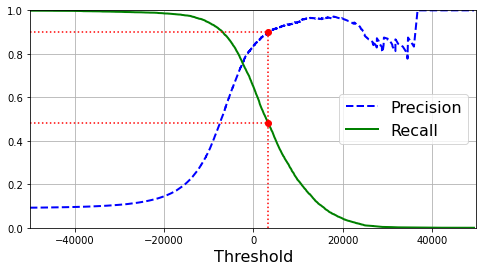

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

- 정밀도(Precision)은 울퉁불퉁한 곡선을 가지는 반면 재현율(Recall)은 완만하다
- 재현율의 분모는 Truly Positive로, threshold 값에 영향을 받지 않는다.
- 정밀도의 분모는 Pred Positive로, threshold 값에 영향을 받는다
- 따라서, 재현율은 반드시 우하향하지만, 정밀도는 반드시 우상향할 필요는 없다.(threshold가 최대일때 정밀도도 최대값 1을 갖긴함)

np.argmax()는 최댓값의 색인을 반환해준다. 수치가 아니라 bool형이면 처음 나오는 True의 색인을 반환 <br>
np.argmin()는 최솟값의 색인을 반환해준다. 수치가 아니라 bool형이면 처음 나오는 False의 색인을 반환

In [ ]:
a = np.array([3,2,1,5,8,78,3])
b = np.array([True,True,False,False,True,False,True,True])
(np.argmax(a), np.argmin(a)), (np.argmax(b), np.argmin(b))

((5, 2), (0, 2))

정밀도가 최소 90%는 달성하는 것이 목표라 가정하고 그때의 임계값을 구해보자 <br>

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

구해진 임계값을 기준으로 예측값을 구해보자

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90[:5]

array([False, False, False, False, False])

마지막으로 정밀도와 재현율을 구한다

In [ ]:
precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
precision_90, recall_90

(0.9000345901072293, 0.4799852425751706)

- precision 최소 90%가 되는 선에서 recall은 0.4799이다.

### ROC 곡선

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

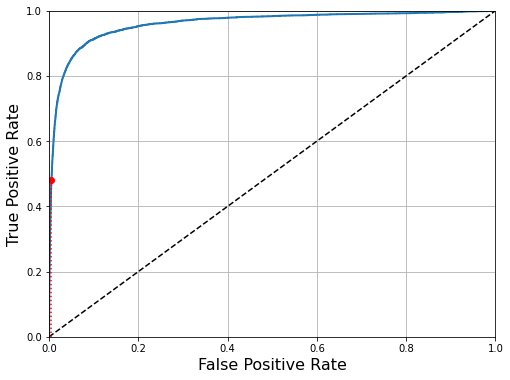

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

AUC 구하기

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

randomForest와 SGD의 RCO curve를 비교해보자 <br>
작동방식의 차이때문에(7장에서) decision_function() 메서드 대신, predict_proba() 메서드가 들어감

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

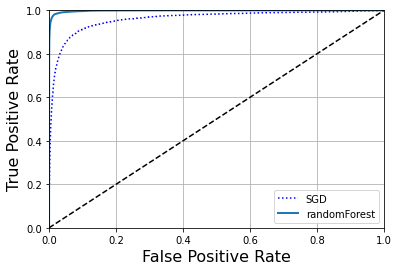

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "randomForest")
plt.legend(loc="lower right")
plt.show()

## 다중 분류

SGD, RandomForest, Naive Bayes같은 분류기는 다중 분류가 직접 가능하지만, 로지스틱(다항분포가 아니라 이항분포를 가정한), SVM과 같은 분류는 다음과 같은 방식으로 다중분류를 진행한다. <br>
- __OVR__(one vs rest) : 1개의 class와 나머지를 구분하는 총 k개(class의 수) 분류기를 만들어, 각 샘플의 결정 점수가 높은 것을 클래스로 선택 <br>
- __OVO__(one vs one) : 총 $_{k}C_{2}$개의 분류기를 만들어 가장 많이 양성으로 분류된 class를 선택

일반적으로 이진 분류 알고리즘에서 OVR이 선호된다. 하지만 SVM과 같이 훈련 셋의 크기에 민감한 모델은 OVO가 선호된다.(OVO는 두 클래스에 해당하는 샘플만 필요하기 때문) <br>
__sklearn.svm.SVC__ 클래스로 svm 다중분류(OVO)

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

some_digit 데이터의 class별 점수를 확인해보자

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

점수가 가장 높은 class를 확인해보자

In [ ]:
idx = np.argmax(some_digit_scores)
svm_clf.classes_[idx]

5

__OneVsOneClassifier__ 또는 __OneVsRestClassifier__ 를 사용하여 OvO나, OvR을 강제할 수 있다.(심지어 이진 분류기일 필요도 없다)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

- 총 10개의 분류기가 만들어짐(OVR).

SGDClassifier 다중 레이블 훈련

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 4번째 decision이 가장 높음(오분류)

교차검증을 통한 정확도 평가

In [ ]:
from sklearn.model_selection import cross_validate
cross_validate(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

{'fit_time': array([131.26620579, 109.37561941, 104.14515805]),
 'score_time': array([0.10372329, 0.06275344, 0.06066823]),
 'test_score': array([0.87365, 0.85835, 0.8689 ])}

혹은 다음의 코드도 가능

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

표준화를 한 후 성능 비교

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 오차 분석

모델 선택, 파라미터 튜닝 과정 등이 진행되었다고 가정하고, 최종모델의 성능을 향상 시키기 위한 방법 중 하나

confusion matrix를 만들어보자

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

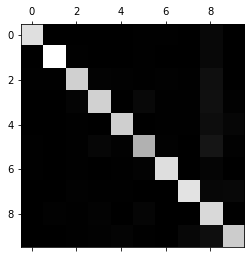

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- count수가 높을수록 밝은색, 비대각원소가 어두운색임을 미루어보아 잘 분류되었음을 알 수 있다.

각 class의 갯수로 나눠줌(비율로)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

주대각원소를 0으로 바꾼 후 출력

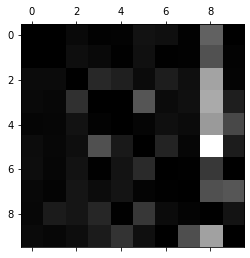

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 5가 8로 잘못분류된 이미지가 많다 (반대는 그렇지 않다)
- 대체로 8로 잘못분류된 이미지가 많다
- 3과 5도 꽤 많이 혼동됨

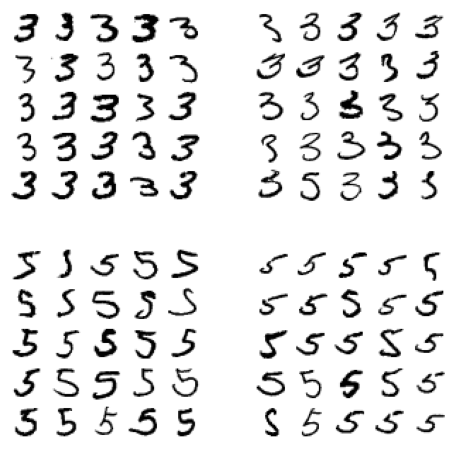

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 대각그림은 제대로 분류된 이미지, 비대각 그림은 잘못 분류된 이미지
- 사람이 식별하기 어려운 이미지도 있으나, 대부분은 분류기 문제
- 선형 모델인 SGDClassifier를 사용해서 나온 문제(단순히 픽셀별 가중치 합을 점수로 계산하기 때문)

## 다중 레이블 분류
앞에서 했던 다중 분류는 각 샘플의 target은 1개의 True 값만 가진다. <br>
다중 레이블은 샘플 target에 2개 이상의 True 값을 가질 수 있다.

KNN 분류기

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 각 레이블의 F1 점수를 계산하고 단순 평균
- 평균에 가중치를 주고싶으면 average = "weighted"

## 다중 출력분류
앞서 했던, 다중 분류와 다중 레이블 분류를 일반화 한것 [참고](https://scikit-learn.org/stable/modules/multiclass.html)

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

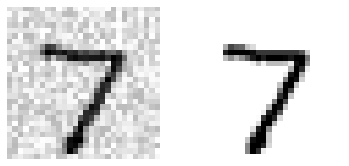

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

- 왼쪽이 feature데이터(X), 오른쪽이 target 데이터(y)

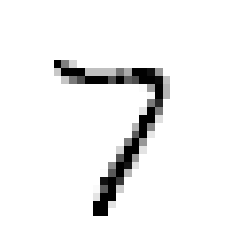

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)